# Visualize personal Gmail inbox traffic over time

Visit https://accounts.google.com/ServiceLogin?service=backup to download your gmail archive as a .mbox file

In [1]:
import mailbox, pandas as pd, numpy as np 
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from dateutil.parser import parse as parse_datetime
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')

## Load the Gmail archive and parse dates/times from messages

In [3]:
# load the mbox file
path = 'gmail.mbox'
mbox = mailbox.mbox(path)
print 'There are {:,} messages in the archive.'.format(len(mbox))

There are 163,381 messages in the archive.


The Gmail mbox file includes emails and hangouts among its "messages". Hangouts messages don't have date/time, so we'll only parse dates and times from the actual emails, and just ignore the hangouts.

In [4]:
# get a list of the dates/times of all the messages in the mbox
all_dates = []
all_times = []
for message in mbox:
    # hangouts messages have no Date key, so handle exception by skipping them
    try:
        date, time = str(parse_datetime(message['Date'])).split(' ')
        all_dates.append(date)
        all_times.append(time)
    except (AttributeError, ValueError):
        pass
print 'There are {:,} messages with dates.'.format(len(all_dates))

There are 34,554 messages with dates.


## Plot the Gmail traffic by date

In [5]:
# get the count per date
date_counts = pd.Series(all_dates).value_counts().sort_index()
print 'There are {:,} dates with messages.'.format(len(date_counts))
date_counts.head()

There are 3,629 dates with messages.


2004-07-27    1
2004-10-27    1
2004-11-04    1
2004-11-07    1
2004-11-17    2
dtype: int64

In [6]:
# not every date has a message, so fill in missing dates in the range with zeros
date_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
index = date_range.map(lambda x: str(x.date()))
date_counts = date_counts.reindex(index, fill_value=0)

print 'There are {:,} dates total in the range, with or without messages.'.format(len(date_counts))
date_counts.head()

There are 4,147 dates total in the range, with or without messages.


2004-07-27    1
2004-07-28    0
2004-07-29    0
2004-07-30    0
2004-07-31    0
dtype: int64

In [7]:
# create a series of labels for the plot: each new year's day
xlabels = pd.Series([label if '01-01' in label else None for label in date_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]
xlabels.head()

158     2005-01-01
523     2006-01-01
888     2007-01-01
1253    2008-01-01
1619    2009-01-01
dtype: object

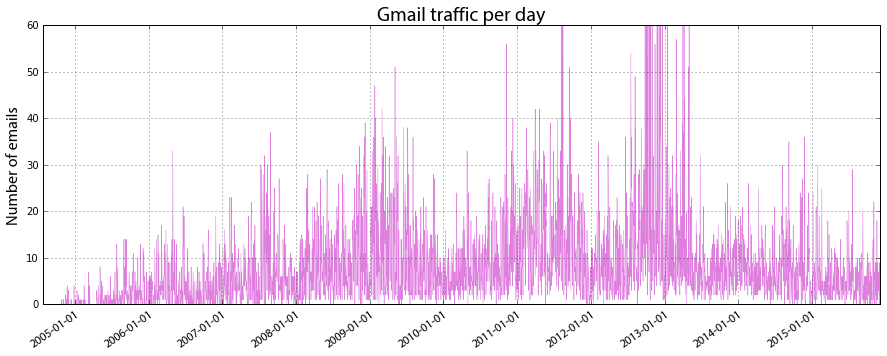

In [8]:
# plot the counts per day
fig = plt.figure(figsize=[15, 5])
ax = date_counts.plot(kind='line', linewidth=0.5, alpha=0.5, color='m')

ax.grid(True)
ax.set_ylim([0, 60])
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic per day', fontproperties=title_font)

plt.show()

## Plot the Gmail traffic by the day of the week

In [9]:
# get the count per day of the week
day_counts = pd.DataFrame()
day_counts['count'] = date_counts
day_counts['day_of_week'] = date_counts.index.map(lambda x: parse_datetime(x).weekday())
mean_day_counts = day_counts.groupby('day_of_week')['count'].mean()
xlabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

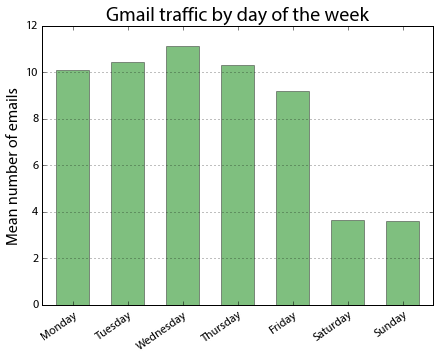

In [10]:
fig = plt.figure(figsize=[7, 5])
ax = mean_day_counts.plot(kind='bar', width=0.6, alpha=0.5, color='g', edgecolor='#333333')

ax.yaxis.grid(True)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Gmail traffic by day of the week', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Mean number of emails', fontproperties=label_font)

plt.show()

## Plot the Gmail traffic by the hour of the day

In [11]:
# get the count per hour of the day
times = pd.Series(all_times).map(lambda x: '{:02}:00'.format(parse_datetime(x).hour))
time_counts = times.value_counts().sort_index()
time_counts.head()

00:00    512
01:00    677
02:00    262
03:00    235
04:00    219
dtype: int64

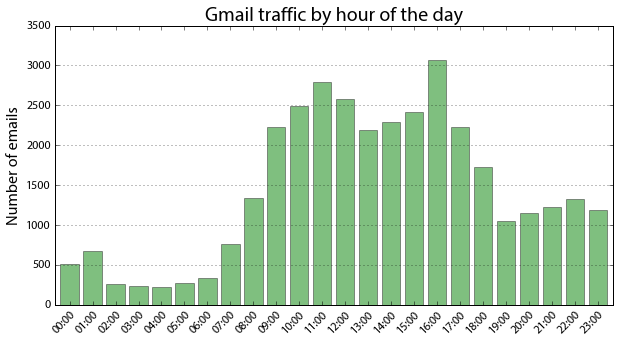

In [12]:
fig = plt.figure(figsize=[10, 5])
ax = time_counts.plot(kind='bar', width=0.8, alpha=0.5, color='g', edgecolor='#333333')

ax.yaxis.grid(True)
ax.set_xticklabels(time_counts.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Gmail traffic by hour of the day', fontproperties=title_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)

plt.show()

## Plot the Gmail traffic by the minute of the day

In [13]:
# get the count per minute of the day, as hh:mm
minutes = pd.Series(all_times).map(lambda x: '{:02}:{:02}'.format(parse_datetime(x).hour, parse_datetime(x).minute))
minute_counts = minutes.value_counts().sort_index()

In [14]:
# not every minute necessarily has a message, so fill in missing times with zeros
time_range = pd.date_range(start='0:00', end='23:59', freq='1min')
index = time_range.map(lambda x: '{:02}:{:02}'.format(x.hour, x.minute))
minute_counts = minute_counts.reindex(index, fill_value=0)

In [15]:
# create a series of labels for the plot: each new hour
xlabels = pd.Series([label if ':00' in label else None for label in minute_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]

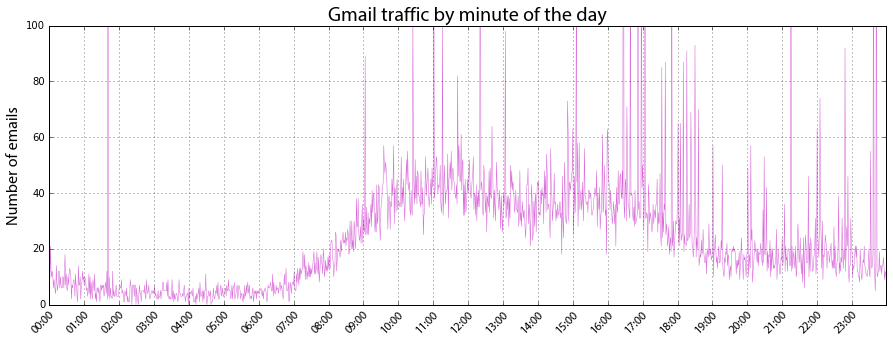

In [16]:
# plot the counts per minute
fig = plt.figure(figsize=[15, 5])
ax = minute_counts.plot(kind='line', linewidth=0.5, alpha=0.6, color='m')

ax.grid(True)
ax.set_ylim([0, 100])
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic by minute of the day', fontproperties=title_font)

plt.show()